In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
url = "https://raw.githubusercontent.com/Prodigy-InfoTech/data-science-datasets/refs/heads/main/Task%204/twitter_training.csv"
df = pd.read_csv(url, header=None)
df.columns = ['ID', 'Entity', 'Sentiment', 'Tweet']


In [5]:
df.shape
df.head()
df['Sentiment'].value_counts()


Sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [11]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = str(text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['Clean_Tweet'] = df['Tweet'].apply(clean_text)


C:\Users\Admin\AppData\Local\Temp\ipykernel_22024\2037884890.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='Set2')


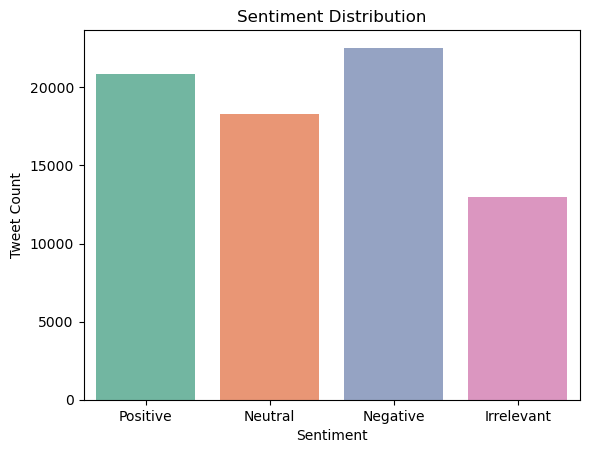

In [13]:
sns.countplot(x='Sentiment', data=df, palette='Set2')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Count')
plt.show()


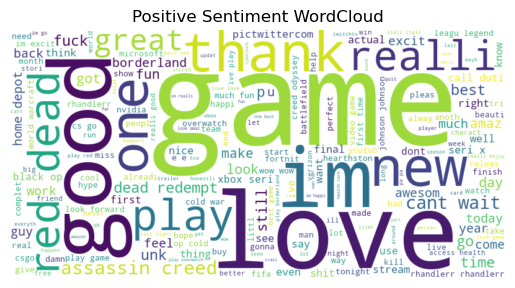

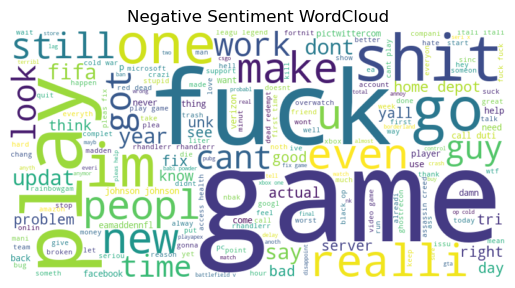

In [15]:
positive_text = ' '.join(df[df['Sentiment'] == 'Positive']['Clean_Tweet'])
negative_text = ' '.join(df[df['Sentiment'] == 'Negative']['Clean_Tweet'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment WordCloud')
plt.show()

wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment WordCloud')
plt.show()


In [17]:
df = df[df['Sentiment'].isin(['Positive', 'Negative', 'Neutral'])]

X = df['Clean_Tweet']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
tfidf = TfidfVectorizer(max_features=3000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [21]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)


              precision    recall  f1-score   support

    Negative       0.68      0.78      0.73      4509
     Neutral       0.68      0.53      0.59      3650
    Positive       0.69      0.72      0.70      4180

    accuracy                           0.68     12339
   macro avg       0.68      0.67      0.67     12339
weighted avg       0.68      0.68      0.68     12339



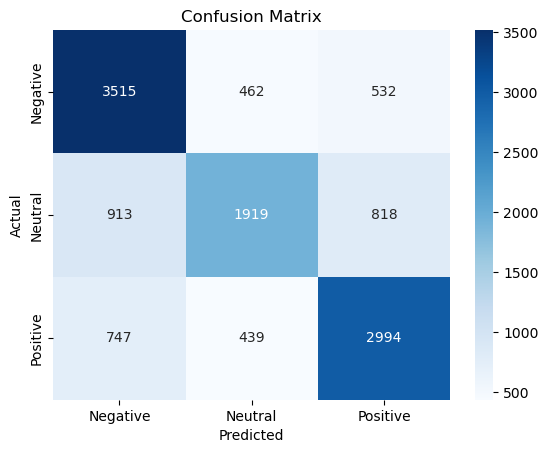

In [23]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


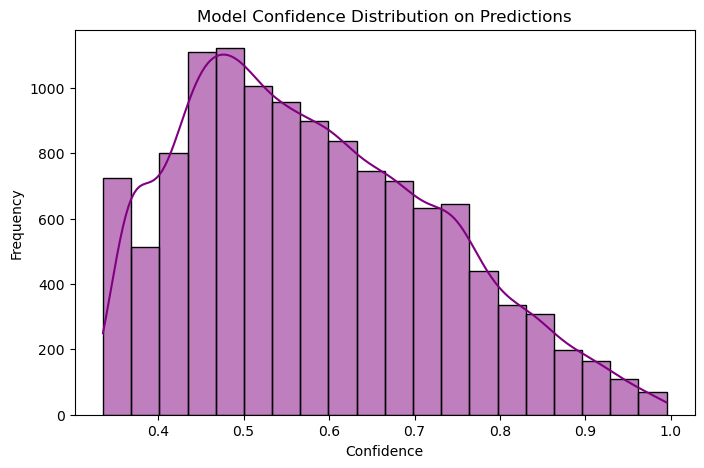

In [27]:
probs = model.predict_proba(X_test_tfidf)
confidences = np.max(probs, axis=1)

plt.figure(figsize=(8,5))
sns.histplot(confidences, bins=20, kde=True, color='purple')
plt.title('Model Confidence Distribution on Predictions')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.show()


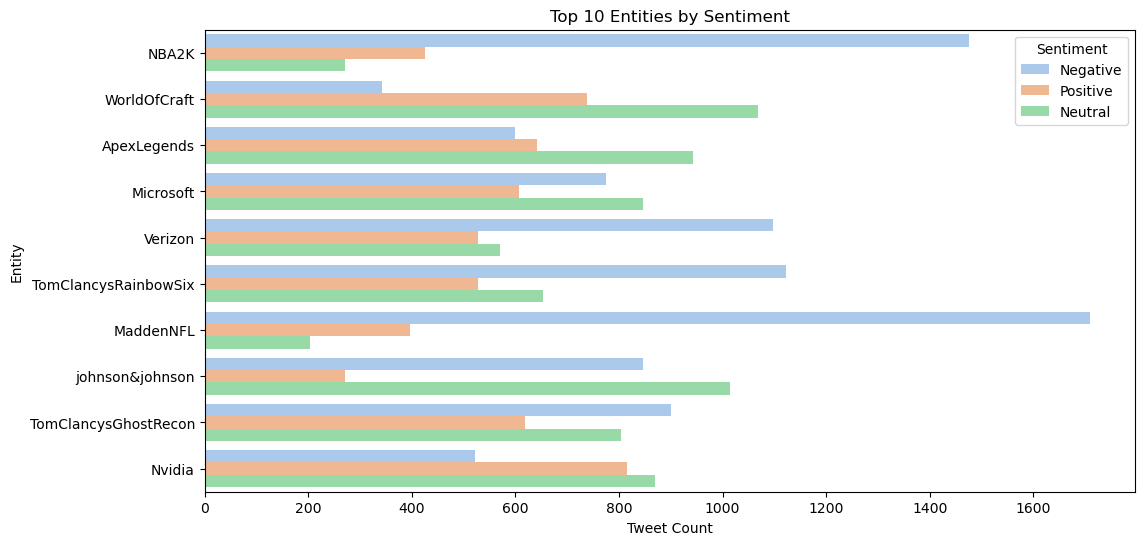

In [29]:
top_entities = df['Entity'].value_counts().head(10).index
subset = df[df['Entity'].isin(top_entities)]

plt.figure(figsize=(12,6))
sns.countplot(data=subset, y='Entity', hue='Sentiment', palette='pastel')
plt.title('Top 10 Entities by Sentiment')
plt.xlabel('Tweet Count')
plt.ylabel('Entity')
plt.legend(title='Sentiment')
plt.show()


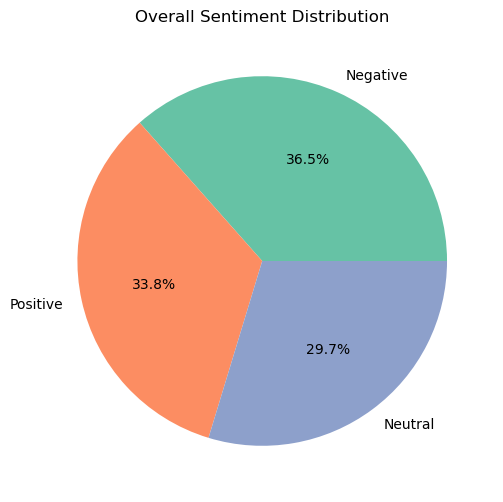

In [31]:
sentiment_counts = df['Sentiment'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Overall Sentiment Distribution')
plt.show()


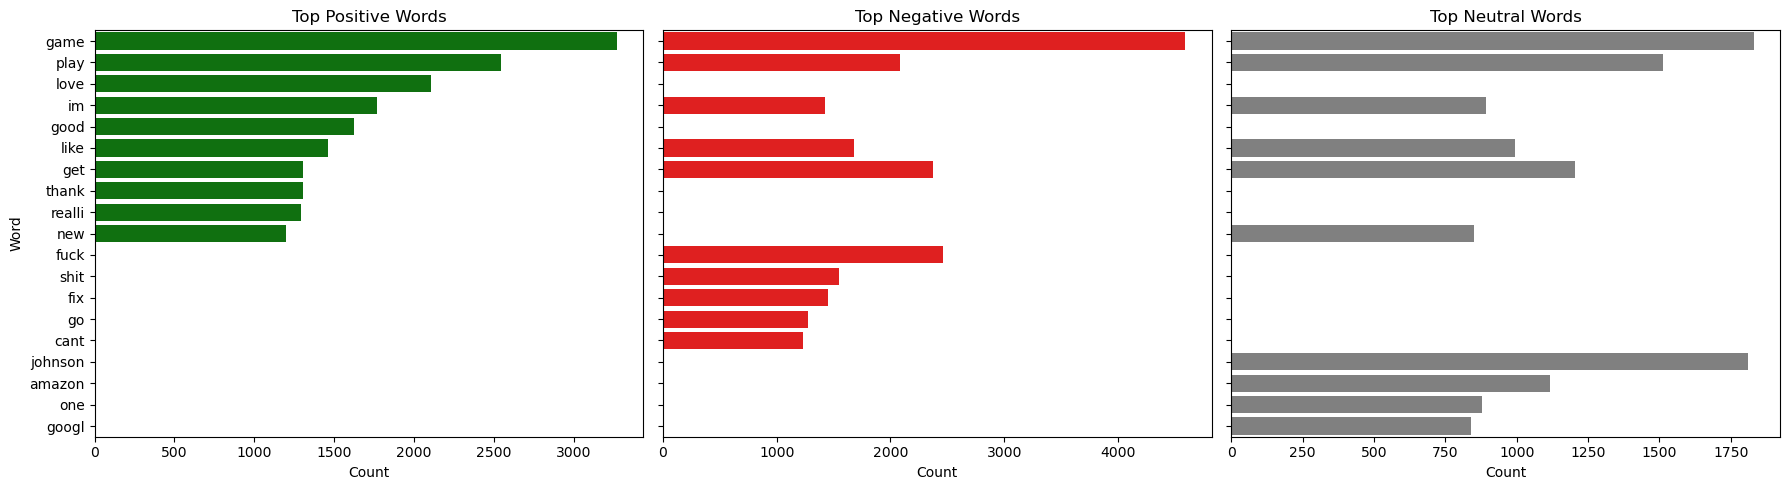

In [33]:
from collections import Counter

def get_top_words(sentiment_label, n):
    words = ' '.join(df[df['Sentiment'] == sentiment_label]['Clean_Tweet']).split()
    most_common = Counter(words).most_common(n)
    return pd.DataFrame(most_common, columns=['Word', 'Count'])

pos_words = get_top_words('Positive', 10)
neg_words = get_top_words('Negative', 10)
neu_words = get_top_words('Neutral', 10)

fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
sns.barplot(data=pos_words, x='Count', y='Word', ax=axes[0], color='green')
axes[0].set_title('Top Positive Words')

sns.barplot(data=neg_words, x='Count', y='Word', ax=axes[1], color='red')
axes[1].set_title('Top Negative Words')

sns.barplot(data=neu_words, x='Count', y='Word', ax=axes[2], color='gray')
axes[2].set_title('Top Neutral Words')

plt.tight_layout()
plt.show()


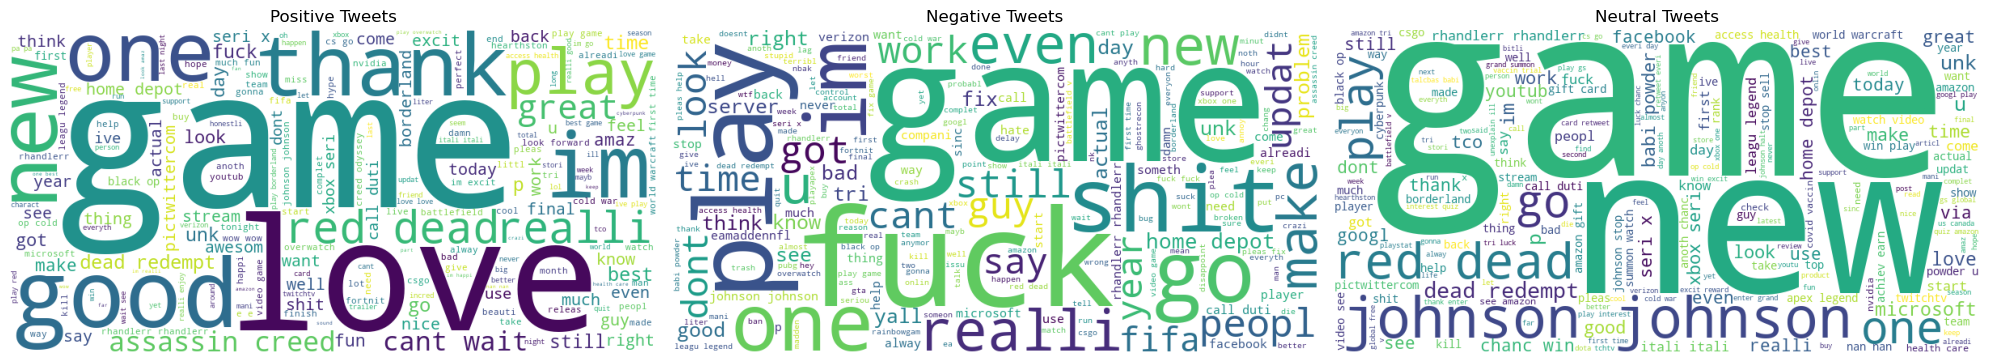

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))

WordCloud(width=800, height=400, background_color='white').generate(
    ' '.join(df[df['Sentiment'] == 'Positive']['Clean_Tweet'])
).to_image().save('positive.png')
img = plt.imread('positive.png')
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Positive Tweets')

WordCloud(width=800, height=400, background_color='white').generate(
    ' '.join(df[df['Sentiment'] == 'Negative']['Clean_Tweet'])
).to_image().save('negative.png')
img = plt.imread('negative.png')
axes[1].imshow(img)
axes[1].axis('off')
axes[1].set_title('Negative Tweets')

WordCloud(width=800, height=400, background_color='white').generate(
    ' '.join(df[df['Sentiment'] == 'Neutral']['Clean_Tweet'])
).to_image().save('neutral.png')
img = plt.imread('neutral.png')
axes[2].imshow(img)
axes[2].axis('off')
axes[2].set_title('Neutral Tweets')

plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

    Negative       0.73      0.79      0.76      4509
     Neutral       0.70      0.63      0.66      3650
    Positive       0.74      0.74      0.74      4180

    accuracy                           0.72     12339
   macro avg       0.72      0.72      0.72     12339
weighted avg       0.72      0.72      0.72     12339



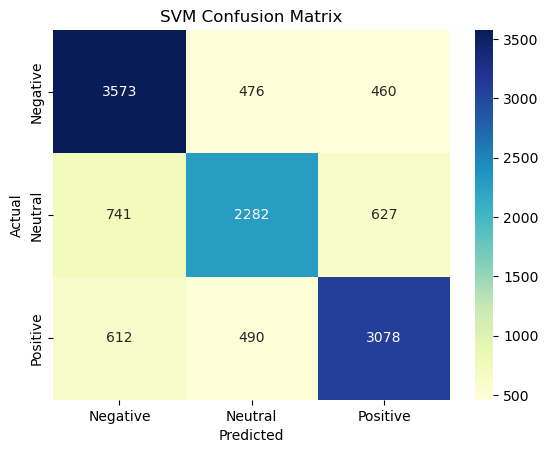

In [37]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


              precision    recall  f1-score   support

    Negative       0.75      0.75      0.75      4509
     Neutral       0.65      0.66      0.65      3650
    Positive       0.74      0.73      0.73      4180

    accuracy                           0.72     12339
   macro avg       0.71      0.71      0.71     12339
weighted avg       0.72      0.72      0.72     12339



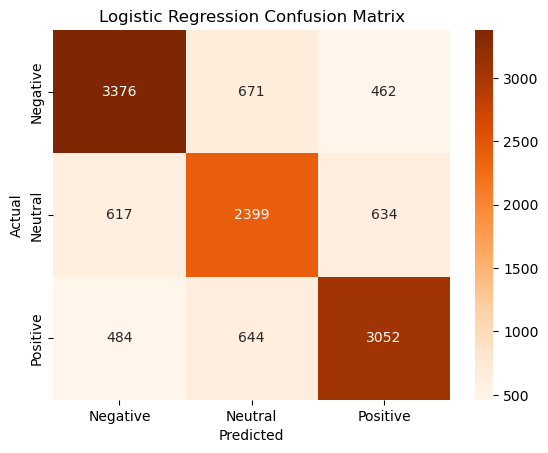

In [39]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_tfidf, y_train)
y_pred_logreg = logreg_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_logreg))

cm_logreg = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Oranges', xticklabels=logreg_model.classes_, yticklabels=logreg_model.classes_)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_22024\1691355517.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


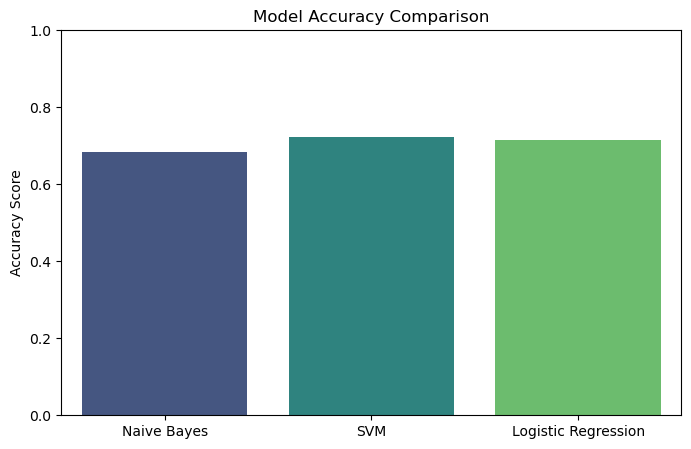

In [41]:
from sklearn.metrics import accuracy_score

acc_nb = accuracy_score(y_test, y_pred)
acc_svm = accuracy_score(y_test, y_pred_svm)
acc_logreg = accuracy_score(y_test, y_pred_logreg)

models = ['Naive Bayes', 'SVM', 'Logistic Regression']
accuracies = [acc_nb, acc_svm, acc_logreg]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy Score')
plt.show()


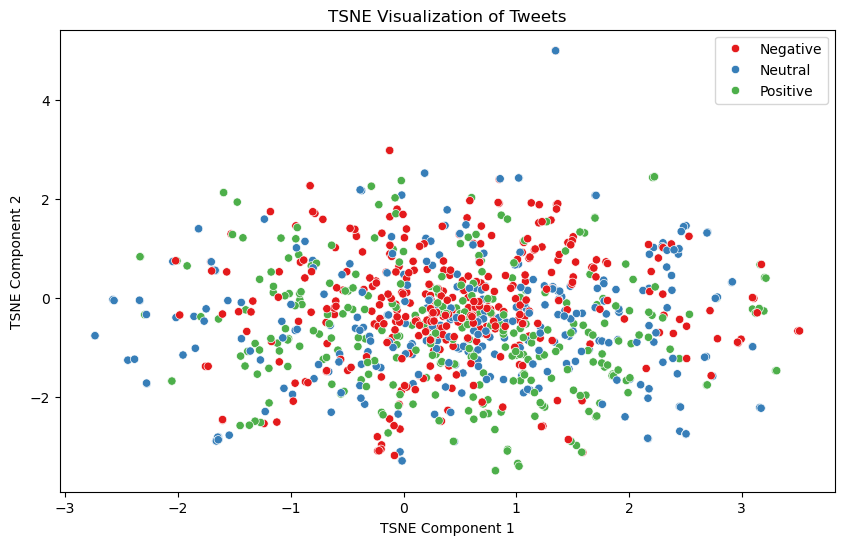

In [43]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=40)
X_reduced = tsne.fit_transform(X_test_tfidf[:1000].toarray())

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=y_test[:1000], palette='Set1')
plt.title('TSNE Visualization of Tweets')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend()
plt.show()


In [45]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    vector = tfidf.transform([cleaned])
    pred_nb = model.predict(vector)[0]
    pred_svm = svm_model.predict(vector)[0]
    pred_log = logreg_model.predict(vector)[0]
    return {
        'Naive Bayes': pred_nb,
        'SVM': pred_svm,
        'Logistic Regression': pred_log
    }

sample_tweet = "The new product launch was fantastic and exciting"
predict_sentiment(sample_tweet)


{'Naive Bayes': 'Positive',
 'SVM': 'Positive',
 'Logistic Regression': 'Positive'}

In [47]:
import joblib

joblib.dump(model, 'naive_bayes_model.pkl')
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(logreg_model, 'logreg_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [49]:
def report_to_df(y_true, y_pred, model_name):
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report_dict).transpose()
    df_report['model'] = model_name
    return df_report

df_nb = report_to_df(y_test, y_pred, 'Naive Bayes')
df_svm = report_to_df(y_test, y_pred_svm, 'SVM')
df_log = report_to_df(y_test, y_pred_logreg, 'Logistic Regression')

all_reports = pd.concat([df_nb, df_svm, df_log])
all_reports.reset_index(inplace=True)
all_reports.head()


,index,precision,recall,f1-score,support,model
0,Negative,0.679227,0.779552,0.725940,4509.000000,Naive Bayes
1,Neutral,0.680496,0.525753,0.593199,3650.000000,Naive Bayes
2,Positive,0.689227,0.716268,0.702487,4180.000000,Naive Bayes
3,accuracy,0.683038,0.683038,0.683038,0.683038,Naive Bayes
4,macro avg,0.682983,0.673858,0.673875,12339.000000,Naive Bayes
